### Technical Data - Exploration and Visualization

This notebook serves to explore and visualize technical data:


In [11]:
import pandas as pd
import pandas_datareader as web
import numpy as np

from collections import Counter
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
import seaborn as sns

In [12]:
days_to_predict = 10

tickers = ['SPY','QQQ','XLF']
start = '2010/01/01'
end = pd.to_datetime('today')

In [13]:
def adv_stock_indicators(df):
    df.reset_index()
    #Simple Moving Averages
    df['SMA12'] = df['Close'].rolling(12).mean()
    df['SMA26'] = df['Close'].rolling(26).mean()

    #Exponential Moving Averages
    df['EMA12'] = df['Close'].ewm(span=12).mean()
    df['EMA26'] = df['Close'].ewm(span=26).mean()

    #Using absolute as difference
    df['SMA12_pctchg'] = abs(((df['Close'] - df['SMA12']) / df['SMA12']) * 100) 
    df['SMA26_pctchg'] = abs(((df['Close'] - df['SMA26']) / df['SMA26']) * 100)
    df['EMA12_pctchg'] = abs(((df['Close'] - df['EMA12']) / df['EMA12']) * 100) 
    df['EMA26_pctchg'] = abs(((df['Close'] - df['EMA26']) / df['EMA26']) * 100) 

    #RSI using EMA
    #Default window length: 14
    delta = df['Close'].diff()
    window_length = 14

    up = delta.copy()
    up[delta<=0]=0.0
    down = abs(delta.copy())
    down [delta>0]=0.0

    RS_up = up.ewm(window_length).mean()
    RS_down = down.ewm(window_length).mean()

    rsi= 100-100/(1+RS_up/RS_down)
    df['RSI'] = rsi

    #MACD
    #Default: Fast Length=EMA12, Slow Length=EMA26, MACD Length=EMA9
    df['MACD'] = df['Close'].ewm(span=12).mean() - df['Adj Close'].ewm(span=26).mean()
    df['MACD_Signal'] = df['MACD'].ewm(span=9).mean()

    #Percent Change
    df['Pct_Chg'] = df['Close'].pct_change() * 100
    
    #Bollinger Bands
    df['Upper_BB'] = df['Close'].rolling(window=20).mean() + (df['Close'].rolling(window=20).std() * 2)
    df['Upper_BB_pctchg'] = abs(((df['Close'] - df['Upper_BB']) / df['Upper_BB']) * 100)

    df['Lower_BB'] = df['Close'].rolling(window=20).mean() - (df['Close'].rolling(window=20).std() * 2)
    df['Lower_BB_pctchg'] = abs(((df['Close'] - df['Lower_BB']) / df['Lower_BB']) * 100)
    
    df['Range_BB'] = (df['Upper_BB'] - df['Lower_BB']) / df['Lower_BB'] * 100
    
    #Candlestick Range
    df['Candlestick_range'] = (df['High'] - df['Low']) / df['Low'] * 100
    
    #Dollar Volume
    df['Dollar_volume'] = df['Close'] * df['Volume']
    df['Rolling_Dollar_volume'] = df['Dollar_volume'].rolling(10).mean()

    df.dropna(inplace=True)

def classify_bullish(current, future):
    if float(future) > float(current):
        return 1
    else:
        return 0
    
def classify_bearish(current, future):
    if float(future) < float(current):
        return 1
    else:
        return 0

def create_df(tickers, start, end, days_to_predict):
    main_df = pd.DataFrame()

    for ticker in tickers:
        df = web.DataReader(ticker, 'yahoo', start, end)

        adv_stock_indicators(df)
        
        df['future'] = df['Adj Close'].shift(-days_to_predict)
        df['bull_target'] = list(map(classify_bullish, df['Adj Close'], df['future']))
        df['bear_target'] = list(map(classify_bearish, df['Adj Close'], df['future']))
        
        df['MACD_sentiment'] = list(map(classify_bullish, df['MACD'], df['MACD_Signal']))
        df['EMA_sentiment'] = list(map(classify_bullish, df['EMA26'], df['EMA12']))
        df['Volume_sentiment']  = list(map(classify_bullish, df['Dollar_volume'], df['Rolling_Dollar_volume']))

        df = df[[
                 'EMA12_pctchg',  
                 'RSI', 
                 'Pct_Chg',
                 'MACD_sentiment',
                 'Upper_BB_pctchg',
                 'Lower_BB_pctchg',
                 'EMA_sentiment',
                 'Volume_sentiment',
                 'bull_target',
                 'bear_target']]
        
        if len(main_df) == 0:
            main_df = df
        else:
            main_df = main_df.append(df)
    
    return main_df

In [14]:
main_df = create_df(tickers, start, end, days_to_predict= days_to_predict)

In [15]:
main_df.head()

,EMA12_pctchg,RSI,Pct_Chg,MACD_sentiment,Upper_BB_pctchg,Lower_BB_pctchg,EMA_sentiment,Volume_sentiment,bull_target,bear_target
Date,,,,,,,,,,
2010-02-09,1.117665,37.752555,1.256022,1,7.876724,2.781412,0,0,1,0
2010-02-10,1.109611,37.155727,-0.195858,1,7.766324,2.873987,0,1,1,0
2010-02-11,0.063021,42.362513,1.046627,1,6.251152,3.919274,0,1,1,0
2010-02-12,0.123556,42.062479,-0.083230,1,5.614527,3.649182,0,0,1,0
2010-02-16,1.220989,49.326200,1.573488,0,3.622338,5.066189,0,1,1,0


In [16]:
main_df.tail()

,EMA12_pctchg,RSI,Pct_Chg,MACD_sentiment,Upper_BB_pctchg,Lower_BB_pctchg,EMA_sentiment,Volume_sentiment,bull_target,bear_target
Date,,,,,,,,,,
2020-12-01,2.151454,64.899978,1.542325,0,4.200955,15.289582,1,0,0,0
2020-12-02,2.753104,66.811221,1.095024,0,3.327664,15.037528,1,0,0,0
2020-12-03,2.349841,66.873553,0.034935,0,3.013212,12.843076,1,1,0,0
2020-12-04,3.030266,69.053449,1.222495,0,1.825976,12.526251,1,0,0,0
2020-12-07,1.955445,66.379122,-0.690127,0,1.762347,9.185978,1,1,0,0


In [17]:
main_df.columns

Index(['EMA12_pctchg', 'RSI', 'Pct_Chg', 'MACD_sentiment', 'Upper_BB_pctchg',
       'Lower_BB_pctchg', 'EMA_sentiment', 'Volume_sentiment', 'bull_target',
       'bear_target'],
      dtype='object')

### Visualizing Technical Indicators

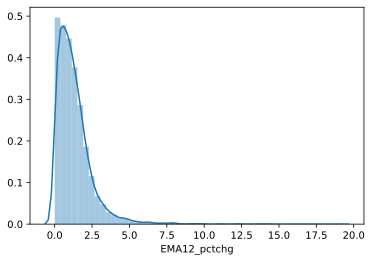

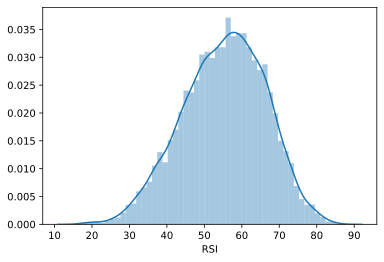

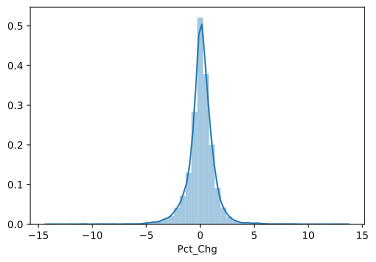

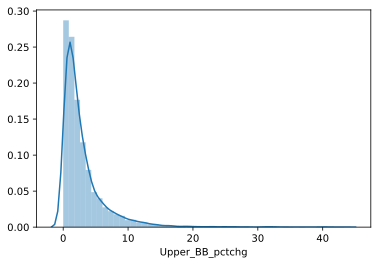

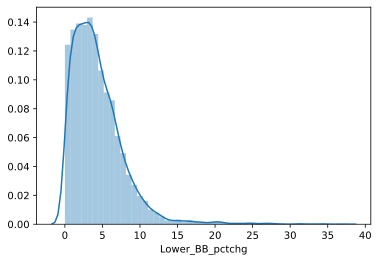

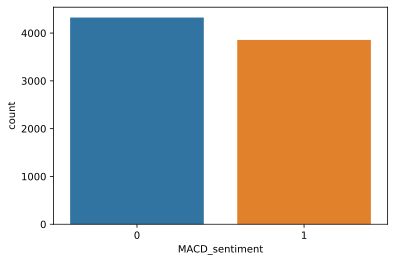

0    4325
1    3856
Name: MACD_sentiment, dtype: int64


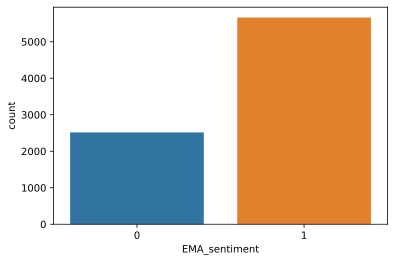

1    5664
0    2517
Name: EMA_sentiment, dtype: int64


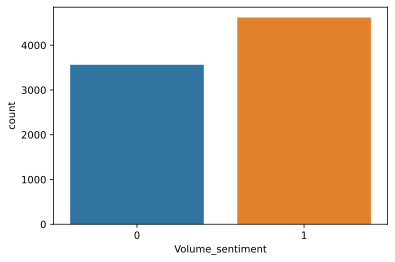

1    4619
0    3562
Name: Volume_sentiment, dtype: int64


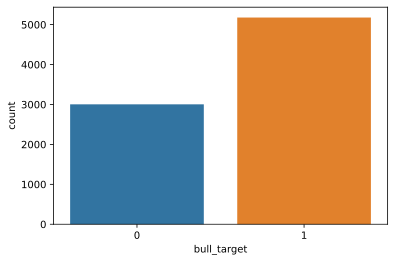

1    5178
0    3003
Name: bull_target, dtype: int64


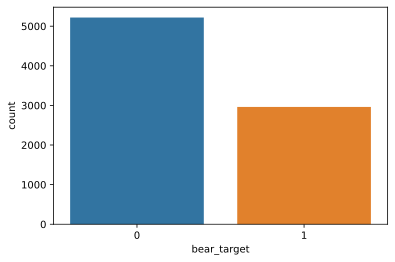

0    5219
1    2962
Name: bear_target, dtype: int64


In [18]:
num_cols = ['EMA12_pctchg', 'RSI', 'Pct_Chg','Upper_BB_pctchg','Lower_BB_pctchg',]
cat_cols = ['MACD_sentiment','EMA_sentiment', 'Volume_sentiment', 'bull_target', 'bear_target']

for col in num_cols:
    sns.distplot(main_df[col], bins=50)
    plt.show()
    
for col in cat_cols:
    sns.countplot(main_df[col])
    plt.show()
    print(main_df[col].value_counts())

In [19]:
main_df.to_csv("data/ta_df.csv")